In [1]:
import sys
import pathlib
sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().parent)))

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import dimod
import dwave
import dwave.system
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import dwave.inspector
import dwave_networkx as dnx
import minorminer
import embera

from src.particle_funcs import distance_matrix as distance_matrix
import src.leap_funcs.qubo.q_matrix as q_matrix

from src import leap_funcs as leap_funcs
from src.leap_funcs import embedding_quality

from src import h5py_funcs
from src.h5py_funcs import discoveries, init_custom_getstates, io, parameterstudy_using_info_file

Custom getstate functions for dwave.cloud.config.models.ClientConfig, dwave.cloud.client.qpu.Client, dwave.cloud.solver.StructuredSolver, dwave.system.samplers.dwave_sampler.DWaveSampler, dwave.system.composites.embedding.FixedEmbeddingComposite have been initialized.


[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1.]


C:\Users\oahre\AppData\Local\Temp\ipykernel_6808\3430350851.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_initial.show()


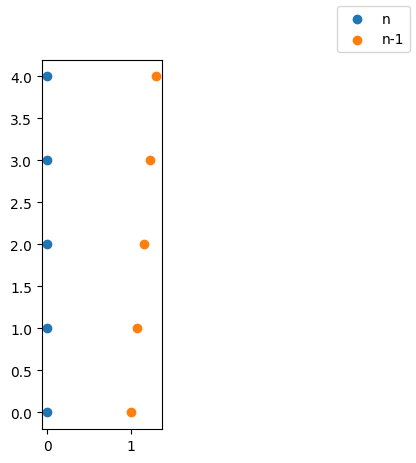

In [2]:
num_particles = 10

part_coords_n = np.zeros((num_particles,2))
part_coords_nm1 = np.zeros((num_particles,2))

for i in range(np.shape(part_coords_n)[0]):
    part_coords_n[i,:] = [0, i]
    part_coords_nm1[i,:] = [1.0*1+0.075*i, i]

fig_initial, axs_initial = plt.subplots(1,1)
axs_initial.scatter(part_coords_n[:,0], part_coords_n[:,1], label="n")
axs_initial.scatter(part_coords_nm1[:,0], part_coords_nm1[:,1], label="n-1")
axs_initial.set_aspect('equal')
fig_initial.legend()
fig_initial.show()

correct_sol = np.zeros(num_particles*num_particles)
for i in range(1, num_particles+1):
    correct_sol[(i-1)*num_particles + i -1] = 1.

print(correct_sol)

In [3]:
distances = distance_matrix.calc_phi_ij(part_coords_n, part_coords_nm1)
Q_dist_diag = q_matrix.q_dist_diag(distances)
Q_part = q_matrix.q_part(np.shape(distances)[0])
Q_pos = q_matrix.q_pos(np.shape(distances)[0])
Q_array = Q_dist_diag + Q_part + Q_pos
Q_dict = q_matrix.Q_convert_to_dict(Q_array)
#with np.printoptions(precision=3, linewidth=1000, threshold=1e6):
#    print(Q_array)

In [4]:
#problem = {
#    'num_vars': 2,
#    'names': ['num_reads', 'num_sweeps'],
#    'sets': np.array([[100,100], [1000,100], [2500,100], [5000,100], [100,1000], [1000,1000], [2500,1000], [5000,1000], [100,2500], [1000,2500], [2500,2500], [5000,2500]])
#}

#problem_salib = {
#    'num_vars': 2,
#    'names': ['num_reads', 'num_sweeps'],
#    'bounds': [[100,5000], [100,2500]]
#}
#samples_salib = salib.sample.sobol.sample(problem_salib, 2)

#print(type(problem['sets']),problem['sets'])
#print(type(problem['sets'][0]), problem['sets'][0])
#print(type(samples_salib), samples_salib)
#print(type(samples_salib[0]), samples_salib[0])
#print(type(samples_salib[0][0]), samples_salib[0][0])

In [5]:
#metadata_dict = {'num_particles': num_particles,
#                 'num_species': 2,
#                 'num_reads': 100,
#                 #'deeper dict': {'key1': 'value1', 'key2': 'value2'}}
#                 'num_sweeps': 100}
#problem_dict = {'num_vars': 2,
#                'names': ['num_reads', 'num_sweeps'],
#                'bounds': [[100,5000], [100,2500]]}
#parametersets_array = np.array([[100,100], [1000,100], [2500,100], [5000,100], [100,1000], [1000,1000], [2500,1000], [5000,1000], [100,2500], [1000,2500], [2500,2500], [5000,2500]])
#np.array([[100,100], [1000,100], [5000,100], [100,1000], [1000,1000], [5000,1000], [100,2500], [1000,2500], [5000,2500]])

#folder_path_name = 'test_workflow_sa_out'
#h5py_funcs.parameterstudy_using_info_file.prepare_info_file(metadata_dict=metadata_dict, problem_dict=problem_dict, parametersets_array=parametersets_array, folder_path_name=folder_path_name)

In [6]:
#with h5py.File('test_workflow_sa_out/parameterstudy_info.h5', 'r') as f:
#    h5py_funcs.discoveries.discover_hdf5_file_structure(f, print_dataset_values=True)
#    a = f['/parametersets/study']
#    print(a.fields('sets')[()])

In [7]:
emb_suffix = ['_mm', '_em', '_em_wo_migration', '_em_layout', '_em_wo_migration_layout']
#file_suffix= ['01', '02', '03', '04', '05', '06', '07', '08', '09']
file_suffix= ['06', '07', '08', '09']

#emb_suffix_id = 0
#file_suffix_id = 0

num_paramsets = 10 # will be turned to num_runs
problem_dict = {'num_vars': 2,
                'names': ['placeholder2', 'placeholde2'],
                'bounds': [[10,20], [11,22]]
                }
parametersets_array = np.array([tuple((1,2)) for i in range(num_paramsets)])
parametersets_array = np.array([[1,2], [1,2], [1,2], [1,2], [1,2], [1,2], [1,2], [1,2], [1,2], [1,2]])




In [8]:
with open('../API_Token_Oliver_QCSE.txt') as file:
    token = file.readline().rstrip()
    architecture = file.readline().rstrip()

for file_suffix_id in range(len(file_suffix)):
    for emb_suffix_id in range(len(emb_suffix)):
        print('file_suffix_id:', file_suffix_id, 'emb_suffix_id:', emb_suffix_id)
        print('file_suffix:', file_suffix[file_suffix_id], 'emb_suffix:', emb_suffix[emb_suffix_id])

        sampler = DWaveSampler(token = token, architecture='pegasus', region='eu-central-1')
        tmp_not_needed_as_a_variable = sampler.adjacency # required for sampler having all data needed for __getstate__, no idea why this is necessary
        sampler_graph = sampler.to_networkx_graph()



        embedding_file_path = 'test_analyze_embedding'
        embedding_file_name = 'analyzes_parts_{}_{}.h5'.format(num_particles, file_suffix[file_suffix_id])
        embedding_file_name_path = os.path.join(embedding_file_path, embedding_file_name)


        embedding_name = 'embedding'+emb_suffix[emb_suffix_id]
        read_embedding = h5py_funcs.io.read_embedding_from_hdf5_file(file_name_path=embedding_file_name_path, data_name=embedding_name)




        folder_path = 'test_embeddings_annealer'
        data_file_name = 'embeddingstudy_data_{}_{}_{}.h5'.format(num_particles, emb_suffix[emb_suffix_id], file_suffix[file_suffix_id])
        data_file_name_path = os.path.join(folder_path, data_file_name)
        info_file_name = 'embeddingstudy_info_{}_{}_{}.h5'.format(num_particles, emb_suffix[emb_suffix_id], file_suffix[file_suffix_id])
        info_file_name_path = os.path.join(folder_path, info_file_name)

        metadata_dict = {'num_particles': num_particles,
                         'embedding_file': embedding_file_name_path
        }
        kwargs_info_file = {'metadata_dict': metadata_dict,
                            'problem_dict': problem_dict,
                            'parametersets_array': parametersets_array,
                            'folder_path_name': folder_path,
                            'info_file_name': info_file_name}
        h5py_funcs.parameterstudy_using_info_file.prepare_info_file(**kwargs_info_file)

        read_parametersets = {}
        with h5py.File(info_file_name_path, 'r') as f:
            read_parametersets['sets'] = f['/parametersets/study'].fields('sets')[()]
            read_parametersets['identifiers'] = f['/parametersets/study'].fields('identifiers')[()]
            read_parametersets['info'] = {key: value for key, value in f['/parametersets'].attrs.items()}
            read_parametersets['attrs'] = {}
            for _id in read_parametersets['identifiers']:
                read_parametersets['attrs'][_id] = {key: value for key, value in f['parametersets']['time_history'][_id].attrs.items()}
        #print(read_parametersets)
        #print(read_parametersets['sets']['num_reads'])
        #print(read_parametersets['sets'].shape)
        print('Number of parametersets:', len(read_parametersets['sets']))
        print('number of identifiers:', len(read_parametersets['identifiers']))
        if len(parametersets_array) == len(read_parametersets['identifiers']):
            num_runs = len(parametersets_array)
        else:
            raise ValueError('Number of identifiers does not match number of parametersets ({} != {})'.format(len(parametersets_array), len(read_parametersets['identifiers'])))
        failed_runs = {}
        for i in range(num_runs):
            try:
                print('start run {} of {}'.format(i+1, num_runs))

                set_identifier = read_parametersets['identifiers'][i]

                if read_parametersets['attrs'][set_identifier]['ready']==True and read_parametersets['attrs'][set_identifier]['finished']==False:
                    pass
                elif read_parametersets['attrs'][set_identifier]['ready']==True and read_parametersets['attrs'][set_identifier]['finished']==True:
                    print('  run {} of {} already finished. Will be skipped'.format(i+1, num_runs))
                    continue
                elif read_parametersets['attrs'][set_identifier]['ready']==False:
                    raise ValueError('  run {} of {} not ready (attr. infofile for set_identifier{}). Will be skipped'.format(i+1, num_runs, set_identifier))

                sampler = DWaveSampler(token = token, architecture='pegasus', region='eu-central-1')
                tmp_not_needed_as_a_variable = sampler.adjacency # required for sampler having all data needed for __getstate__, no idea why this is necessary
                composite = FixedEmbeddingComposite(sampler, read_embedding)

                h5py_funcs.parameterstudy_using_info_file.update_timestamp_in_info_file(file_name_path=info_file_name_path, set_identifier=set_identifier, name='start')

                #kwargs = {key: read_parametersets['sets'][key][i][0] for key in read_parametersets['sets'].dtype.names} # ['sets'][key][i][0] : [0] is required because have shape (1,) 
                kwargs_annealer = {'label' : data_file_name+set_identifier.decode('utf-8'),
                                    'annealing_time': 20, 
                                    'num_reads': 1000, 
                                    'answer_mode': 'raw', 
                                    'programming_thermalization': 1000, 
                                    #'readout_thermalization': 0
                                    }
                
                #print(kwargs)
                #sampleset={'sample_1': 'sample_1', 'sample_2': 'sample_2', 'info': {}}
                sampleset = composite.sample_qubo(Q_dict, **kwargs_annealer)
                print('  successfully finished sampling')
                print('  start writing data to file')

                dict_data = {'sampleset': sampleset.to_serializable(pack_samples=False), 'set_identifier': set_identifier}
                #dict_data = {'sampleset': sampleset, 'set_identifier': set_identifier}
                kwargs_write_sampleset = {'file_name_path': data_file_name_path,
                                           'dict_data': dict_data,
                                           'data_name': 'sampleset',
                                            #'name_suffix': set_identifier.decode('utf-8'), 
                                            'overwrite_data_in_file': False,
                                            'track_order': True}
                h5py_funcs.io.write_to_hdf5_file(**kwargs_write_sampleset)
                h5py_funcs.parameterstudy_using_info_file.update_timestamp_in_info_file(file_name_path=info_file_name_path, set_identifier=set_identifier, name='finish')
                print('  successfully finished writing data to file')
            except Exception as e: 
                #e='hi'
                print('  failed run {} of {}, check message for info, samples might still be vaild'.format(i+1, num_runs))
                failed_runs[f'{i}'] = {'set_identifier': set_identifier, 'Message': e}
                continue
        print('number of failed runs: {}'.format(len(failed_runs)), ' Failed runs:', failed_runs)

file_suffix_id: 0 emb_suffix_id: 0
file_suffix: 06 emb_suffix: _mm


Created new info-file embeddingstudy_info_5__mm_06.h5 in folder test_embeddings_annealer.
Number of parametersets: 10
number of identifiers: 10
start run 1 of 10
  successfully finished sampling
  start writing data to file
  successfully finished writing data to file
start run 2 of 10
  successfully finished sampling
  start writing data to file
  successfully finished writing data to file
start run 3 of 10
  successfully finished sampling
  start writing data to file
  successfully finished writing data to file
start run 4 of 10
  successfully finished sampling
  start writing data to file
  successfully finished writing data to file
start run 5 of 10
  successfully finished sampling
  start writing data to file
  successfully finished writing data to file
start run 6 of 10
  successfully finished sampling
  start writing data to file
  successfully finished writing data to file
start run 7 of 10
  successfully finished sampling
  start writing data to file
  successfully finished wr

In [12]:
import src.leap_funcs.qubo.filter_samples

for file_suffix_id in range(len(file_suffix)):
    for emb_suffix_id in range(len(emb_suffix)):
        count_optimal_samples = 0
        print('file_suffix_id:', file_suffix_id, 'emb_suffix_id:', emb_suffix_id)
        print('file_suffix:', file_suffix[file_suffix_id], 'emb_suffix:', emb_suffix[emb_suffix_id])

        folder_path = 'test_embeddings_annealer'
        data_file_name = 'embeddingstudy_data_{}_{}_{}.h5'.format(num_particles, emb_suffix[emb_suffix_id], file_suffix[file_suffix_id])
        data_file_name_path = os.path.join(folder_path, data_file_name)
        info_file_name = 'embeddingstudy_info_{}_{}_{}.h5'.format(num_particles, emb_suffix[emb_suffix_id], file_suffix[file_suffix_id])
        info_file_name_path = os.path.join(folder_path, info_file_name)
        
        samples_dict = {}
        with h5py.File(data_file_name_path, 'r') as f:
            _ids = [key for key in f['sampleset'].keys()]
            for _id in _ids:
                samples_dict[_id] = f['sampleset'][_id]['sample_data']['data'][()]
        #print(samples_dict[_ids[0]][0])

        for _id in _ids:
            ids_valid_solutions= []
            for k, sol in enumerate(samples_dict[_id]):
                    #print(sol)
                    #print(sol[0])
                    parts = 0
                    poss = 0
                    valid_parts = True
                    valid_poss = True
                    for i in range(num_particles):
                        parts = 0
                        for j in range(num_particles):
                            parts += sol[i*num_particles +j]
                        #print('parts ', parts)
                        if parts != 1:
                            valid_parts = False

                    for j in range(num_particles):
                        poss = 0
                        for i in range(num_particles):
                            poss += sol[i*num_particles +j]
                        #print('poss ', poss)
                        if poss != 1:
                            valid_poss = False

                    if valid_parts and valid_poss:
                        ids_valid_solutions.append(k)
            #print(ids_valid_solutions)

            for i, sol in enumerate(samples_dict[_id]):

                #print(sol)
                #print(correct_sol.astype(int))
                #print(correct_sol.astype(int) - sol)
                if i in ids_valid_solutions:
                    if np.array_equal(correct_sol.astype(int), sol):
                        #print('sol', i, 'is valid and optimal')
                        #print(' ', sol)
                        count_optimal_samples += 1
        print(count_optimal_samples)

file_suffix_id: 0 emb_suffix_id: 0
file_suffix: 06 emb_suffix: _mm
901
file_suffix_id: 0 emb_suffix_id: 1
file_suffix: 06 emb_suffix: _em
1261
file_suffix_id: 0 emb_suffix_id: 2
file_suffix: 06 emb_suffix: _em_wo_migration
2011
file_suffix_id: 0 emb_suffix_id: 3
file_suffix: 06 emb_suffix: _em_layout
1533
file_suffix_id: 0 emb_suffix_id: 4
file_suffix: 06 emb_suffix: _em_wo_migration_layout
1526
file_suffix_id: 1 emb_suffix_id: 0
file_suffix: 07 emb_suffix: _mm
1056
file_suffix_id: 1 emb_suffix_id: 1
file_suffix: 07 emb_suffix: _em
1402
file_suffix_id: 1 emb_suffix_id: 2
file_suffix: 07 emb_suffix: _em_wo_migration
1444
file_suffix_id: 1 emb_suffix_id: 3
file_suffix: 07 emb_suffix: _em_layout
2285
file_suffix_id: 1 emb_suffix_id: 4
file_suffix: 07 emb_suffix: _em_wo_migration_layout
1553
file_suffix_id: 2 emb_suffix_id: 0
file_suffix: 08 emb_suffix: _mm
2404
file_suffix_id: 2 emb_suffix_id: 1
file_suffix: 08 emb_suffix: _em
1689
file_suffix_id: 2 emb_suffix_id: 2
file_suffix: 08 emb_su